## Order of convergence lower order

In [ ]:
#Various tests of the order of convergence and stability regions for lower order methods and IDC and RIDC methods

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt  
import sympy as sy
from scipy.interpolate import lagrange

F = lambda t,y : 4*t*y**(0.5)
F_sol = lambda t : (1+t**2)**2

G = lambda t,y : 0*y
G_sol = lambda t : np.exp(-0.1*t)

In [2]:
#explicit Euler's method

def Euler(times, f, y0):
    no_of_times = times.size 
    Y = np.zeros((no_of_times))
    
    Y[0] = y0
    for i in range(no_of_times-1):
        h = times[i+1] - times[i]
        Y[i+1] = Y[i] + h*f(times[i],Y[i])
        
    return Y



In [3]:
T = np.linspace(0, 1, 101)
y0 = 1.0

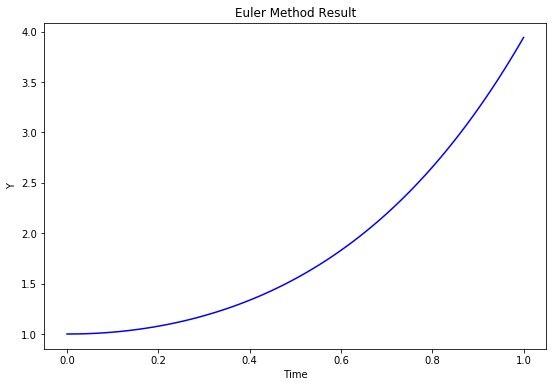

In [4]:
K = Euler(T,F,y0)


fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(T, K, 'b-', markersize=2)
#plt.plot(T, (1+T**2)**2, 'r-', markersize=2)
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('Euler Method Result')
plt.show()



In [5]:
#Runge-Kutta

def Runge_Kutta_4(times,f,y0):
    no_of_times = times.size                                                
    Y = np.zeros((no_of_times))             
                                                      
    Y[0] = y0  
    for i in range(no_of_times-1):  
        h = times[i+1] - times[i]  
        delta1 = f(times[i],Y[i]) * h 
        delta2 = f(times[i]+1/2*h,Y[i]+1/2*delta1) * h  
        delta3 = f(times[i]+h/2,Y[i]+delta2/2) * h 
        delta4 = f(times[i]+h,Y[i]+delta3) * h 
        Y[i+1] = Y[i] + 1/6*(delta1+2*delta2+2*delta3+delta4) 
    return Y


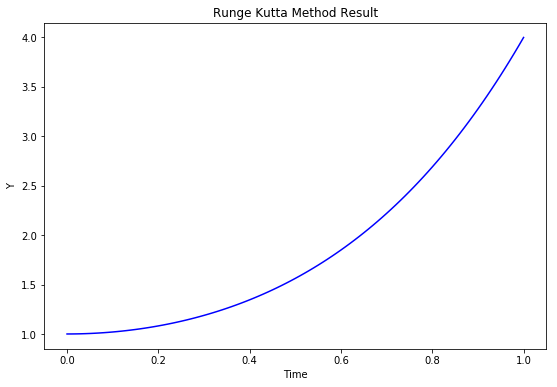

In [6]:
K1 = Runge_Kutta_4(T,F,y0)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(T, K1, 'b-', markersize=2)
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('Runge Kutta Method Result')
plt.show()


In [7]:
def beta(M):
    '''
    Generates beta coefficients for Adam-Bashforth integrating scheme
    These coefficients are stored in reversed compared to conventional
    Adam-Bashforth implementations (the first element of beta corresponds to
    earlier point in time).
    input:
    M: the order of Adam-Bashforth scheme
    '''
    if M == 2:
        return np.array([-1./2, 3./2])
    elif M == 3:
        return np.array([5./12, -16./12, 23./12])
    elif M == 4:
        return np.array([-9./24, 37./24, -59./24, 55./24])
    elif M == 5:
        return np.array([251./720, -1274./720, 2616./720, -2774./720, 1901./720])
    elif M == 6:
        return np.array([-475./720, 2877./720, -7298./720, 9982./720, -7923./720, 4277./720])


def Ab4(F,T,y0,N):
    betavec = beta(4)
    h = float(T)/N
    ts = np.linspace(0,T,N+1)
    d = len(y0)
    Y = np.zeros((N+1,d))
    Y[0,:] = y0
    
    for t in range(3):
        KK1 = F(ts[t],Y[t,:])
        KK2 = F(ts[t]+h/2, Y[t,:]+KK1*h/2)
        KK3 = F(ts[t]+h/2, Y[t,:]+KK2*h/2)
        KK4 = F(ts[t]+h,Y[t,:]+KK3*h)
        Y[t+1,:] = Y[t,:] + h*(KK1 + 2*KK2 + 2*KK3 + KK4)/6
    for t in range(3,N):
        L = np.array([F(ts[t-3],Y[t-3,:]),F(ts[t-2],Y[t-2,:]),F(ts[t-1],Y[t-1,:]),F(ts[t],Y[t,:])])
        Y[t+1,:] = Y[t,:] +h*np.dot(betavec,L)
        
    return Y

# IDCp-FE

In [174]:
#integral deferred correction


def IDC(a,b,N,p,y0,F):
    #(a,b)-endpoints, N-number of steps, p-order of method, y0-I.C

    h = (b-a)/N  #stepsize
    M = p-1  
    J = int(N/M)
    d = len(y0)
    sol_list = np.zeros((N+1,d))
    sol_list[0,:] = y0
    T = np.zeros((J,M+1,d))  #times
    Y = np.zeros((J,M+1,d))  #approx solution
    Y1 = np.zeros((J,M+1,d))   #corrected solution
    Y[0,0,:]= y0            #inital value
    S = np.zeros((M,M+1))  #integration matrix
    
    for m in range(M):   # calculating integration matrix
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)  # constructs polynomial
            para = np.poly1d.integ(p)  
            S[m,i] = para(m+1) - para(m)  #finds definite integral of polynomial and adds to integral matrix
            
    for j in range(J):
        for m in range(M):   #prediction
            T[j,m] = (j*M + m)*h
            T[j,m+1] = (j*M + m+1)*h
            Y[j,m+1,:] = Y[j,m,:] + h*(F(T[j,m],Y[j,m,:])) #Eulers forward method  
            
        for l in range(1,M+1):   #correction
            Y1[j,0,:] = Y[j,0,:]
            
            for m in range(M):  
                g = 0
                for k in range(M+1):
                    g = g + S[m,k]*F(T[j,k],Y[j,k,:])
   
                Y1[j,m+1,:] = Y1[j,m,:] + h*(F(T[j,m],Y[j,m,:])-F(T[j,m],Y1[j,m,:])) + h*g  #solve error equation with forward Euler
            Y[j,:,:] = Y1[j,:,:]
    
        sol_list[j*M+1:j*M+M+1,:] = Y1[j,1:M+1,:]
        if j!=J-1:           #set initial value for next iteration
            Y[j+1,0,:] = Y1[j,M,:]
            
    return sol_list



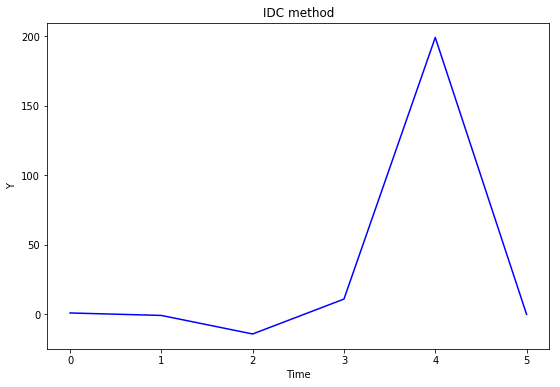

In [9]:
G = lambda t,y : -2*y
T1 = np.linspace(0,5,6)
K2 = IDC(0,5,5,3,np.array([1.0]),G)

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(T1, K2, 'b-', markersize=2)
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('IDC method')
plt.show()

## Order of convergence calculations Lower order

In [10]:
def func_sol(T):  #exact solution
    
    y_t = (1+T**2)**2
    
    return np.array([y_t])

G = lambda t,y : y
G_sol = lambda t : np.exp(t)

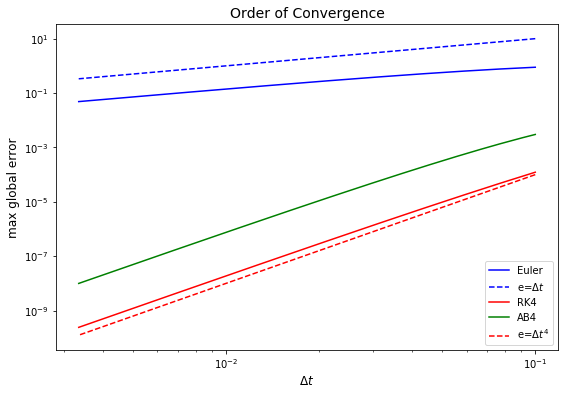

In [11]:
#Finding order of convergence for Euler method

errorlist = []
stepsizelist = []

for i in range(10,300):    #timestep sizes from h=1 t h=0.01
    T = np.linspace(0, 2, i+1)
    K = Euler(T,G,1)
    stepsizelist.append(1/(i))
    m = [abs(K[j] - G_sol(T[j])) for j in range(i)]
    errorlist.append(max(m))
    
errorlist1 = []
stepsizelist1 = []
    
for i in range(10,300):    #timestep sizes from h=1 t h=0.01
    T = np.linspace(0, 2, i+1)
    K = Runge_Kutta_4(T,G,1)
    stepsizelist1.append(1/(i))
    m = [abs(K[j] - G_sol(T[j])) for j in range(i)]
    errorlist1.append(max(m))
    
errorlist2 = []
stepsizelist2 = []
    
for i in range(10,300):    #timestep sizes from h=1 t h=0.01
    T = np.linspace(0, 2, i+1)
    K = Ab4(G,2,np.array([1]),i)
    stepsizelist2.append(1/(i))
    m = [abs(K[j] - G_sol(T[j])) for j in range(i)]
    errorlist2.append(max(m))
    
test = [100*i for i in stepsizelist]
test1 = [i**4 for i in stepsizelist]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(stepsizelist, errorlist, 'b-', markersize=2,label ="Euler")
plt.plot(stepsizelist, test, 'b--', markersize=2, label = "e=$\Delta t$")
plt.plot(stepsizelist1, errorlist1, 'r-', markersize=2,label ="RK4")
plt.plot(stepsizelist2, errorlist2, 'g-', markersize=2,label ="AB4")
plt.plot(stepsizelist1, test1, 'r--', markersize=2,label ="e=$\Delta t^{4}$")
ax.set_xscale('log')
ax.set_yscale('log')
#plt.plot(stepsizelist, errorlist, 'r-', markersize=2)
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.legend()
plt.title('Order of Convergence',fontsize = 14)
plt.savefig('Eulerorder.png')
plt.show()

## Stability Tests Lower order


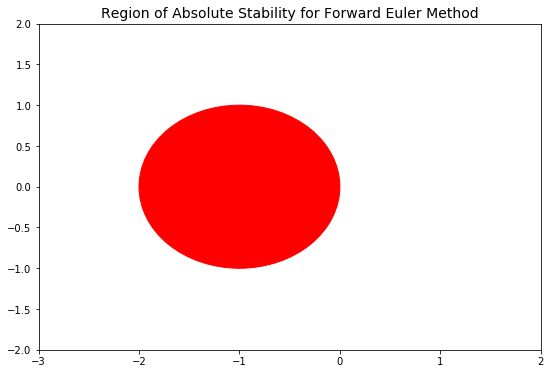

In [12]:
circle1 = plt.Circle((-1, 0),1, color='r')
#circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue')
#circle3 = plt.Circle((1, 1), 0.2, color='g', clip_on=False)

fig, ax = plt.subplots(1,1,figsize=(9, 6)) # note we must use plt.subplots, not plt.subplot

plt.xlim(-3,2)
plt.ylim(-2,2)
ax.add_patch(circle1)

#plt.xlabel('$\Delta t$',fontsize = 12)
#plt.ylabel(r'max global error',fontsize = 12)
plt.title('Region of Absolute Stability for Forward Euler Method',fontsize = 14)
plt.savefig('Eulersatbility.png')
plt.show()

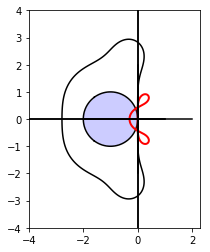

In [13]:
#for single step


def plotS(R, axisbox = [-2, 2, -2, 2]):
    nptsx = 501
    nptsy = 501
    xa, xb, ya, yb = axisbox
    x = np.linspace(xa,xb,nptsx)
    y = np.linspace(ya,yb,nptsy)
    X,Y = np.meshgrid(x,y)
    Z = X + 1j*Y
    Rabs = abs(R(Z))
    levels = [-1e9,1,1e9]
    Sregion_color = [0.8, 0.8, 1.]   # RGB 
    plt.contourf(X,Y,Rabs,levels,colors=[Sregion_color,'w'])
    plt.contour(X,Y,Rabs,[1],colors='k') # boundary
    
    # plot axes
    plt.plot([xa, xb], [0, 0], 'k')
    plt.plot([0, 0], [ya, yb], 'k')
    plt.axis(axisbox)
    plt.axis('scaled')  # so circles are circular
    
#For multistep
    
def plotBL(rho, sigma, axisbox = [-2, 2, -2, 2]):
    theta = np.linspace(0, 2*np.pi, 1000)
    eitheta = np.exp(1j * theta)
    z = rho(eitheta) / sigma(eitheta)

    plt.plot(z.real, z.imag, 'r', linewidth=2)
    
    # plot axes
    xa, xb, ya, yb = axisbox
    plt.plot([xa, xb], [0, 0], 'k')
    plt.plot([0, 0], [ya, yb], 'k')
    plt.axis(axisbox)
    plt.axis('scaled')
    
R = lambda z: 1+z
Q = lambda z: 1+z+1/2*z**2+1/6*z**3+1/24*z**4
S = lambda z: (24.0*(z**4-z**3))/(55*z**3-59*z**2+37*z-9.)

rho = lambda z: 24.0*(z**4-z**3)
sigma = lambda z: 55*z**3-59*z**2+37*z-9.
rho1 = lambda z: -1.+z
sigma1 = lambda z: 1.
rho2 = lambda z: 1.+z+1/2*z**2+1/6*z**3+1/24*z**4
sigma2 = lambda z: 1.


axisbox = [-4,1,-4,4]
plotBL(rho,sigma)
#plotBL(rho1,sigma1)
#plotBL(rho2,sigma2)

plotS(Q, axisbox)

plotS(R, axisbox)

/Users/Sam/anaconda3/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'label'
  s)


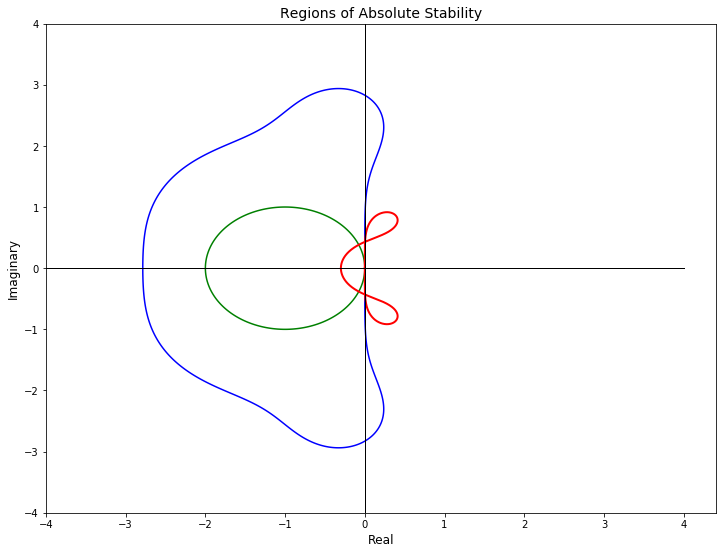

In [14]:
def plotBL(rho, sigma, axisbox = [-2, 2, -2, 2]):
    theta = np.linspace(0, 2*np.pi, 1000)
    eitheta = np.exp(1j * theta)
    z = rho(eitheta) / sigma(eitheta)
    return z.real,z.imag

def plotS(R, axisbox = [-2, 2, -2, 2]):
    nptsx = 501
    nptsy = 501
    xa, xb, ya, yb = axisbox
    x = np.linspace(xa,xb,nptsx)
    y = np.linspace(ya,yb,nptsy)
    X,Y = np.meshgrid(x,y)
    Z = X + 1j*Y
    Rabs = abs(R(Z))
    return Rabs,X,Y

R = lambda z: 1+z
Q = lambda z: 1+z+1/2*z**2+1/6*z**3+1/24*z**4
rho = lambda z: 24.0*(z**4-z**3)
sigma = lambda z: 55*z**3-59*z**2+37*z-9.

A1,A2 = plotBL(rho,sigma)
B1,B2,B3 = plotS(Q, axisbox)
C1,C2,C3 = plotS(R, axisbox)

fig, ax = plt.subplots(1, 1, figsize=(12, 9))
plt.xlabel('Real',fontsize = 12)
plt.ylabel('Imaginary',fontsize = 12)
plt.title('Regions of Absolute Stability',fontsize = 14)
a1 = plt.contour(B2,B3,B1,[1],colors='b',label = 'RK4')
b1 = plt.contour(C2,C3,C1,[1],colors='g',label = 'Euler')
c1 = plt.plot(A1, A2, 'r', linewidth=2, label = 'AB4')
plt.plot([-4, 4], [0, 0], 'k',linewidth=1)
plt.plot([0, 0], [-4, 4], 'k',linewidth=1)
plt.savefig('Stability.png')


plt.show()

## Order of convergence IDC

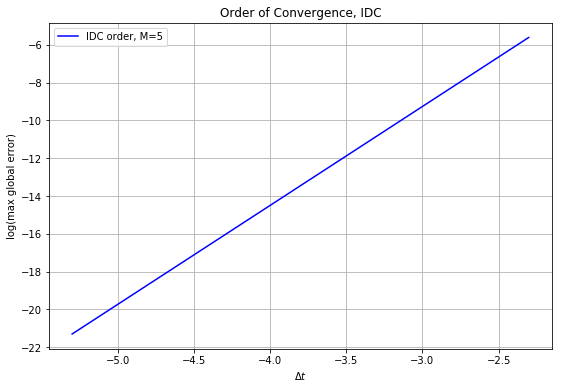

In [175]:
errorlistt = []
stepsizelistt = []

for i in [10,200]:   
    T = np.linspace(0, 2, i+1)
    K2 = IDC(0,2,i,6,np.array([1]),F)
    stepsizelistt.append(1/(i))
    m = [abs(K2[j] - func_sol(T[j])) for j in range(i)]
    errorlistt.append(max(m))
    
logerrorlist2 = [np.log(i) for i in errorlistt]
logstepsizelist2 = [np.log(i) for i in stepsizelistt]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(logstepsizelist2, logerrorlist2, 'b-', markersize=2, label = 'IDC order, M=5')
#plt.plot([-2,-5],[5.58*-2,5.58*-5], 'r-')
plt.grid()
plt.xlabel('$\Delta t$')
plt.ylabel(r'log(max global error)')
plt.title('Order of Convergence, IDC')
plt.legend()

plt.show()

In [176]:
errorlist2 = []
stepsizelist2 = []

for i in [10,200]:   
    T = np.linspace(0, 2, i+1)
    K2 = IDC(0,2,i,2,np.array([1]),F)
    stepsizelist2.append(1/(i))
    m = [abs(K2[j] - func_sol(T[j])) for j in range(i)]
    errorlist2.append(max(m))
    
errorlist3 = []
stepsizelist3 = []

for i in [10,200]:   
    T = np.linspace(0, 2, i+1)
    K2 = IDC(0,2,i,3,np.array([1]),F)
    stepsizelist3.append(1/(i))
    m = [abs(K2[j] - func_sol(T[j])) for j in range(i)]
    errorlist3.append(max(m))
    
errorlist4 = []
stepsizelist4 = []

test = 5
for i in [12,201]:   
    T = np.linspace(0, 2, i+1)
    K2 = IDC(0,2,i,4,np.array([1]),F)
    stepsizelist4.append(1/(i))
    m = [abs(K2[j] - func_sol(T[j])) for j in range(i)]
    errorlist4.append(max(m))

errorlist5 = []
stepsizelist5 = []


for i in [12,200]:   
    T = np.linspace(0, 2, i+1)
    K2 = IDC(0,2,i,5,np.array([1]),F)
    stepsizelist5.append(1/(i))
    m = [abs(K2[j] - func_sol(T[j])) for j in range(i)]
    errorlist5.append(max(m))
    
errorlist6 = []
stepsizelist6 = []


for i in [10,210]:   
    T = np.linspace(0, 2, i+1)
    K2 = IDC(0,2,i,6,np.array([1]),F)
    stepsizelist6.append(1/(i))
    m = [abs(K2[j] - func_sol(T[j])) for j in range(i)]
    errorlist6.append(max(m))
    

    
test = [100*i**5 for i in stepsizelist5]
test1 = [i**2 for i in stepsizelist2]

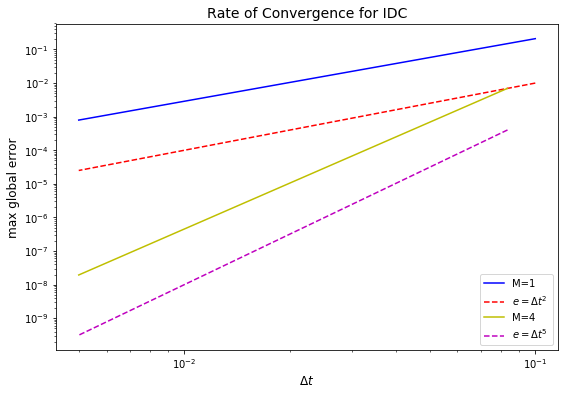

In [177]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(stepsizelist2, errorlist2, 'b-', markersize=2, label = 'M=1')
plt.plot(stepsizelist2, test1,'r--',markersize=2,label = '$e = \Delta t^{2}$ ' )
#plt.plot(stepsizelist3, errorlist3, 'r-', markersize=2, label = 'M=2')
#plt.plot(stepsizelist4, errorlist4, 'm-', markersize=2, label = 'M=3')
plt.plot(stepsizelist5, errorlist5, 'y-', markersize=2, label = 'M=4')
plt.plot(stepsizelist5, test,'m--',markersize=2, label = '$e = \Delta t ^{5}$ ' )
#plt.plot(stepsizelist6, errorlist6, 'p-', markersize=2, label = 'M=5')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for IDC',fontsize = 14)
plt.savefig('IDCorder1.png')
plt.show()


In [18]:

h = np.zeros(10)
l=[]
a=[]
b=[]

for i in [201,1002]:   
    T = np.linspace(0, 1, i+1)
    K2 = IDC(0,1,i,4,np.array([1]),F)
    b.append(np.log(1/(i-1)))
    m = [abs(K2[j] - F_sol(T[j])) for j in range(i)]
    a.append(np.log(max(m)))
l.append(((a[1]-a[0])/(b[1]-b[0])))

l,a,b

([array([3.96461266])],
 [array([-19.00564151]), array([-25.39040206])],
 [-5.298317366548036, -6.90875477931522])

In [39]:
def func2d(t, y):
    y1 = y[0]
    y2 = y[1]
    y1_p = -y2 + y1*(1-y1**2-y2**2)
    y2_p = y1 + 3*y2*(1-y1**2-y2**2)
    return np.array([y1_p, y2_p])

def func_sol2d(t):
    y1_p = np.cos(t)
    y2_p = np.sin(t)
    return np.array([y1_p, y2_p])


In [40]:
K2 = IDC(0,10,999,4,np.array([1.0,0]),func2d)
K3 = IDC(0,10,998,3,np.array([1.0,0]),func2d)

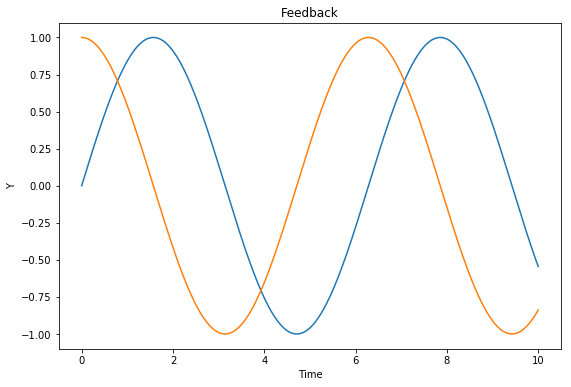

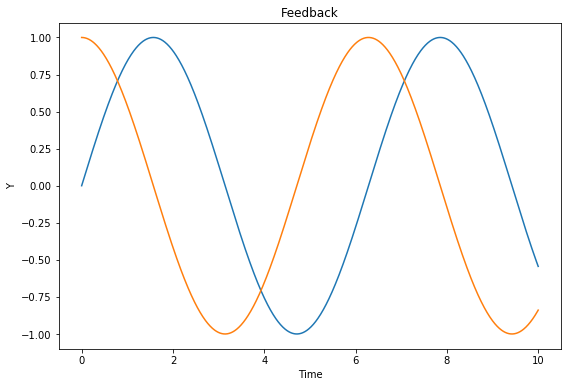

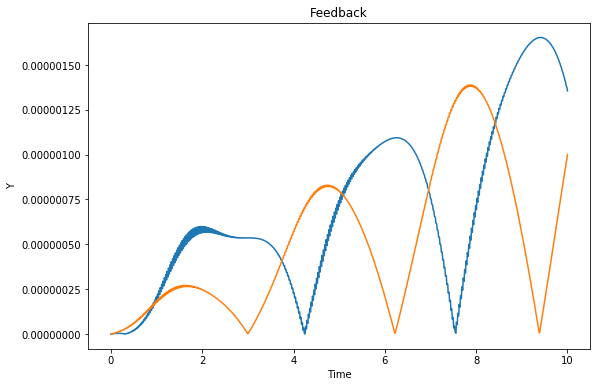

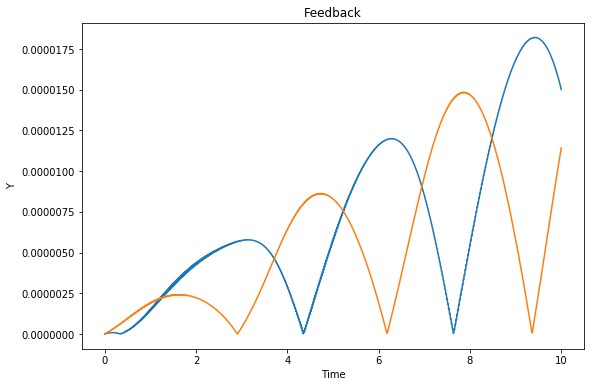

1.6531864353054593e-06

In [41]:
T = np.linspace(0,10,1000)
T1 = np.linspace(0,10,999)
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(T,K2[:,1] , label='No feedback')
ax.plot(T,K2[:,0], label='No feedback')
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('Feedback')


fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(T,func_sol2d(T)[1] , label='No feedback')
ax.plot(T,func_sol2d(T)[0], label='No feedback')
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('Feedback')


fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(T,abs(K2[:,1] - func_sol2d(T)[1]) , label='No feedback')
ax.plot(T,abs(K2[:,0] - func_sol2d(T)[0]), label='No feedback')
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('Feedback')

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.plot(T1,abs(K3[:,1] - func_sol2d(T1)[1]) , label='No feedback')
ax.plot(T1,abs(K3[:,0] - func_sol2d(T1)[0]), label='No feedback')
plt.xlabel('Time')
plt.ylabel(r'Y')
plt.title('Feedback')
plt.show()


max(abs(K2[:,1] - func_sol2d(T)[1]))

In [42]:
errorlist10 = []
stepsizelist10 = []

for i in [200,999]:   
    T = np.linspace(0, 10, i+1)
    K2 = IDC(0,10,i,3,np.array([1.0,0]),func2d)
    stepsizelist10.append(1/(i-1))
    m = [abs(K2[j,0] - func_sol2d(T[j])[0]) for j in range(i)]
    errorlist10.append(max(m))
    
errorlist11 = []
stepsizelist11 = []

for i in [200,999]:   
    T = np.linspace(0, 10, i+1)
    K2 = IDC(0,10,i,2,np.array([1.0,0]),func2d)
    stepsizelist11.append(1/(i-1))
    m = [abs(K2[j,0] - func_sol2d(T[j])[0]) for j in range(i)]
    errorlist11.append(max(m))
    
errorlist12 = []
stepsizelist12 = []

for i in [201,999]:   
    T = np.linspace(0, 10, i+1)
    K2 = IDC(0,10,i,4,np.array([1.0,0]),func2d)
    stepsizelist12.append(1/(i-1))
    m = [abs(K2[j,0] - func_sol2d(T[j])[0]) for j in range(i)]
    errorlist12.append(max(m))
    


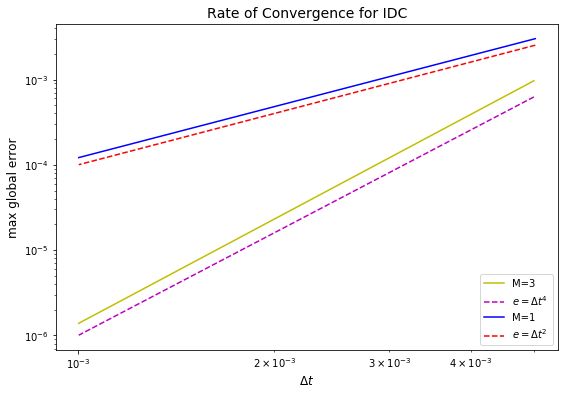

In [43]:
test = [i**3 for i in stepsizelist10]
test1 = [10**2*i**2 for i in stepsizelist11]
test2 = [10**6*i**4 for i in stepsizelist12]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))

plt.plot(stepsizelist12, errorlist12, 'y-', markersize=2, label = 'M=3')
plt.plot(stepsizelist12, test2,'m--',markersize=2,label = '$e = \Delta t^{4}$ ' )

#plt.plot(stepsizelist10, errorlist10, 'b-', markersize=2, label = 'M=2')
#plt.plot(stepsizelist10, test1,'r--',markersize=2,label = '$e = \Delta t^{3}$ ' )

plt.plot(stepsizelist11, errorlist11, 'b-', markersize=2, label = 'M=1')
plt.plot(stepsizelist11, test1,'r--',markersize=2,label = '$e = \Delta t^{2}$ ' )

ax.set_xscale('log')
ax.set_yscale('log')
plt.legend(loc="lower right") 
plt.xlabel('$\Delta t$',fontsize = 12)
plt.ylabel(r'max global error',fontsize = 12)
plt.title('Rate of Convergence for IDC',fontsize = 14)
plt.savefig('IDCorder2.png')
plt.show()

# RIDC(p,k)-FE

In [44]:
#revised integral deferred correction


#revised integral deferred correction


def RIDC(a,b,N,p,K,y0,F):#Euler
    #(a,b)-endpoints, N-number of steps, p-order of method, K- No. intervals,  y0-I.C, F-function

    h = (b-a)/N  #stepsize
    M = p-1  
    J = int(N/K)
    sol_list = np.zeros(N+1) #stores the solution
    sol_list[0] = y0
    T = np.zeros((J,K+1))
    times = np.linspace(a,b,N+1)
    for j in range(J):
        T[j,0:K+1] = times[j*K:j*K+K+1] #times
    Y = np.zeros((J,K+1))  #approx solution
    Y1 = np.zeros((J,K+1))   #corrected solution
    Y[0,0]= y0            #inital value
    S = np.zeros((M,M+1))  #integration matrix
    
    for m in range(M):   # calculating integration matrix
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)  # constructs polynomial
            para = np.poly1d.integ(p)  
            S[m,i] = para(m+1) - para(m)  #finds definite integral of polynomial and adds to integral matrix
            
    for j in range(J):
        Y[:, 0] = sol_list[j*K]  # predictor starts w last point in j-1 interval
        for m in range(K):   #prediction
            Y[j,m+1] = Y[j,m] + h*F(T[j,m],Y[j,m]) #Eulers forward method  
            
        for l in range(1,M+1):   #correction
            Y1[j,0] = Y[j,0]
            
            for m in range(M):  
                
                g = sum([S[m,k]*F(T[j,k],Y[j,k]) for k in range(M+1)])

                Y1[j,m+1] = Y1[j,m] + h*(F(T[j,m],Y1[j,m])-F(T[j,m],Y[j,m])) + h*g #solve error equation with forward Euler
            
            for m in range(M,K):
                
                g = sum([S[M-1,k]*F(T[j,m-M+k+1],Y[j,m-M+k+1]) for k in range(M+1)])
                
                Y1[j,m+1] = Y1[j,m] + h*(F(T[j,m],Y1[j,m])-F(T[j,m],Y[j,m])) + h*g  #solve error equation with forward Euler
                    
            Y[j,:] = Y1[j,:]
    
        sol_list[j*K+1:j*K+K+1] = Y1[j,1:K+1]

            
    return sol_list




## Running time for IDC

In [25]:
import time

start = time.perf_counter()
K = IDC(0,1,1000,2,np.array([1]),F)
finish = time.perf_counter()
print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 0.04 second(s)


In [26]:
start = time.perf_counter()
K = IDC(0,1,1000,3,np.array([1]),F)
finish = time.perf_counter()
print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 0.11 second(s)


In [27]:
start = time.perf_counter()
K = IDC(0,1,1000,4,np.array([1]),F)
finish = time.perf_counter()
print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 0.17 second(s)


In [28]:
start = time.perf_counter()
K = IDC(0,1,1000,5,np.array([1]),F)
finish = time.perf_counter()
print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 0.24 second(s)


In [29]:
start = time.perf_counter()
K = IDC(0,1,1000,6,np.array([1]),F)
finish = time.perf_counter()
print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 0.34 second(s)


In [30]:
start = time.perf_counter()
K = IDC(0,1,1000,7,np.array([1]),F)
finish = time.perf_counter()
print(f'Finished in {round(finish-start, 2)} second(s)')

Finished in 1.26 second(s)


In [31]:
#start = time.perf_counter()
#K = IDC(0,1,1000,10,np.array([1]),F)
#finish = time.perf_counter()
#print(f'Finished in {round(finish-start, 2)} second(s)')

In [32]:
#start = time.perf_counter()
#K = IDC(0,1,1000,11,np.array([1]),F)
#finish = time.perf_counter()
#print(f'Finished in {round(finish-start, 2)} second(s)')

In [33]:

#d =[]
#for k in range(2,12):
  #  l = []
  #  for m in range(20):
   #     start = time.perf_counter()
   #     IDC(0,1,1000,k,np.array([1]),F)
  #      finish = time.perf_counter()
  #      l.append(round(finish-start,5))
  #  d.append(sum(l)/20)
#l

In [34]:
#d
#fig, ax = plt.subplots(1, 1, figsize=(9, 6))
#plt.plot([1,2,3,4,5,6,7,8,9,10], d, 'o', color='black')
#plt.grid()

#plt.xlabel('M',fontsize = 12)
#plt.ylabel(r'Time (seconds)',fontsize = 12)
#plt.title('Time for different values of M',fontsize = 13)
#plt.savefig('IDCtime.png')
#plt.show()

## Numerical absolute stability region

### Euler

In [45]:
#Euler test

delta_t = 1
testeq = lambda l,y : -l*y
def Eulertesteq(T,l):
    y = np.zeros(T+1,dtype=complex)
    y[0] = 1
    for i in range(T):
        y[i+1] = y[i]+testeq(l,y[i])
    return y


goodlistRe = []
goodlistIm = []
#Finding the real values that for the stability interval
for i in np.arange(0,2.005,0.005):
    M = Eulertesteq(10,i)

    df = [abs(M[j]) for j in range(1,11)]
    
    r = max(df)

    if r<=1.:
        goodlistRe.append(round(-i,6))
#finding the maximum imaginary values correcsponding to the real ones that satisfy the amplification factor
for m in goodlistRe:
    goodlistIm1 = []
    for i in np.arange(0,1.001,0.001):
        
        M = Eulertesteq(10,complex(-m,i))
        #print(M)
        dl = [abs(M[j]) for j in range(1,11)]
        #print(df)
        r = max(dl)
        #print(r)
        if r<=1.:
            goodlistIm1.append(round(i,6))
    something = max(goodlistIm1)
    goodlistIm.append(round(something,6))
        

        
#goodlistRe,goodlistIm

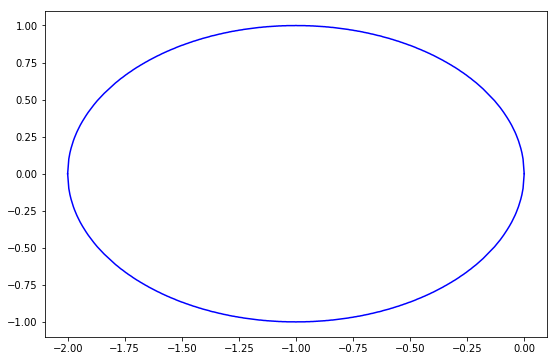

In [46]:
a_zip = zip(goodlistRe,goodlistIm)
l = list(a_zip)


x_val2 = [x[0] for x in l]
y_val2 = [x[1] for x in l]
y1_val2 = [-x[1] for x in l]

fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(x_val2,y_val2,'b')
plt.plot(x_val2,y1_val2,'b')

plt.show()

### RK4

In [47]:
testeq = lambda l,y : l*y

def RKtesteq(l):
    y = np.zeros(11,dtype=complex)
    y[0] = 1
    for i in range(10):
        delta1 = testeq(l,y[i]) 
        delta2 = testeq(l,y[i]+1/2*delta1)    
        delta3 = testeq(l,y[i]+1/2*delta2)  
        delta4 = testeq(l,y[i]+delta3) 
        y[i+1] = y[i] + 1/6*(delta1+2*delta2+2*delta3+delta4) 
    return y

RKtesteq(-2.7)

array([1.        +0.j, 0.8788375 +0.j, 0.77235535+0.j, 0.67877485+0.j,
       0.59653279+0.j, 0.52425538+0.j, 0.46073529+0.j, 0.40491145+0.j,
       0.35585137+0.j, 0.31273553+0.j, 0.27484371+0.j])

In [48]:
#RK4 test 

goodlistRe = []
goodlistIm = []
#Finding the real values that for the stability interval
for i in np.arange(0,3.005,0.005):
    M = RKtesteq(-i)

    df = [abs(M[j]) for j in range(1,11)]
    #print(df)
    r = max(df)
    #print(r)
    if r<=1.:
        goodlistRe.append(round(-i,6))
#print(goodlistRe)
#finding the maximum imaginary values correcsponding to the real ones that satisfy the amplification factor
for m in goodlistRe:
    goodlistIm1 = []
    for i in np.arange(0,3.005,0.005):
        
        M = RKtesteq(complex(m,i))
        #print(M)
        dl = [abs(M[j]) for j in range(1,11)]
        #print(df)
        r = max(dl)
        #print(r)
        if r<=1.:
            goodlistIm1.append(round(i,6))
    something = max(goodlistIm1)
    goodlistIm.append(round(something,6))
    
        

        
goodlistRe,goodlistIm
a_zipRK = zip(goodlistRe,goodlistIm)

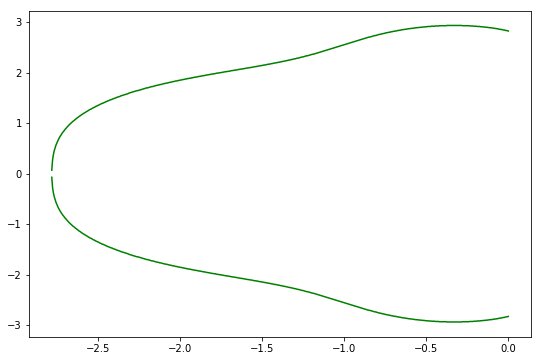

In [49]:
a_zipRK = zip(goodlistRe,goodlistIm)
work  = list(a_zipRK)
x_val3 = [x[0] for x in work]
y_val3 = [x[1] for x in work]
y_val31 = [-x[1] for x in work]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

plt.plot(x_val3,y_val3,'g')
plt.plot(x_val3,y_val31,'g')

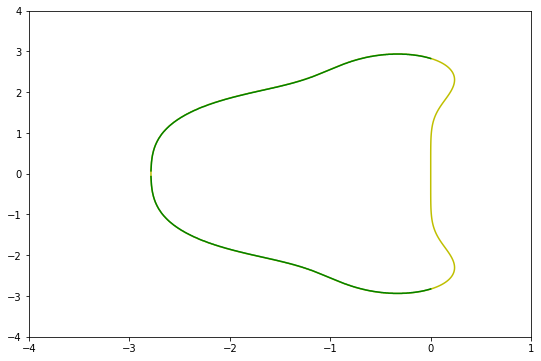

In [54]:


fig, ax = plt.subplots(1, 1, figsize=(9, 6))
#plt.plot(x_val1,y_val1,'b')
#plt.plot(x_val1,y1_val1,'b')
plt.plot(x_val3,y_val3,'g')
plt.plot(x_val3,y_val31,'g')
a1 = plt.contour(B2,B3,B1,[1],colors='y',label = 'RK4')
plt.show()

### IDC

In [173]:
#testing for IDC

testeq = lambda l,y : l*y

def IDCtesteq(l,p):
    #l - lambda value, p - order so M=p-1

    
    M = p-1  
    J = 100
    sol_list = np.zeros(J*M+1,dtype=complex)
    sol_list[0] = 1.
    T = np.arange(0,J*M+1,1)  #times
    Y = np.zeros((J,M+1),dtype=complex)  #approx solution
    Y1 = np.zeros((J,M+1),dtype=complex)   #corrected solution
    Y[0,0]= 1           #inital value
    S = np.zeros((M,M+1))  #integration matrix
    
    for m in range(M):   # calculating integration matrix
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)  # constructs polynomial
            para = np.poly1d.integ(p)  
            S[m,i] = para(m+1) - para(m)  #finds definite integral of polynomial and adds to integral matrix
            
    for j in range(J):
        for m in range(M):   #prediction
            Y[j,m+1] = Y[j,m] + testeq(l,Y[j,m]) #Eulers forward method  
        #print(Y)
        for l1 in range(1,M+1):   #correction
            Y1[j,0] = Y[j,0]
            
            for m in range(M):  
                g = 0
                for k in range(M+1):
                    g = g + S[m,k]*testeq(l,Y[j,k])
                    #print(g)
                Y1[j,m+1] = Y1[j,m] + (testeq(l,Y[j,m])-testeq(l,Y1[j,m])) + g  #solve error equation with forward Euler
            Y[j,:] = Y1[j,:]
        #print(Y1)
        sol_list[j*M+1:j*M+M+1] = Y1[j,1:M+1]
        #print(sol_list)
        if j!=J-1:           #set initial value for next iteration
            Y[j+1,0] = Y1[j,M]
        
    return sol_list








In [90]:
goodlistRe = []
goodlistIm = []
#Finding the real values that for the stability interval
for i in np.arange(0,2.005,0.005):
    M = IDCtesteq(-i,4)
    #print(M)
    df = [abs(M[j]) for j in range(1,4)]
    #print(df)
    r = max(df)
    #print(r)
    if r<=1.:
        goodlistRe.append(round(-i,6))
#print(goodlistRe)
#finding the maximum imaginary values correcsponding to the real ones that satisfy the amplification factor
for m in goodlistRe:
    goodlistIm1 = []
    for i in np.arange(0,1.005,0.005):
        
        M = IDCtesteq(complex(m,i),4)
        #print(M)
        dl = [abs(M[j]) for j in range(1,4)]
        #print(df)
        r = max(dl)
        #print(r)
        if r<=1.:
            goodlistIm1.append(round(i,6))

    something = max(goodlistIm1)
    goodlistIm.append(round(something,6))
        

        


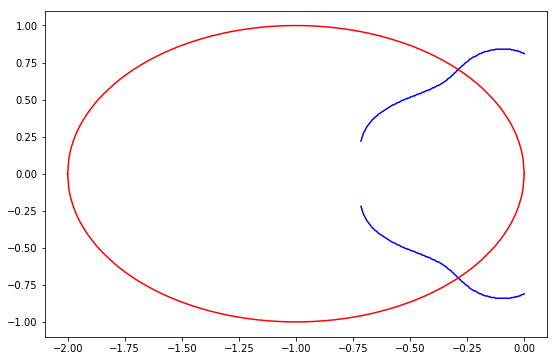

In [91]:
a_zip = zip(goodlistRe,goodlistIm)
l = list(a_zip)

x_val = [x[0] for x in l]
y_val = [x[1] for x in l]
y1_val = [-x[1] for x in l]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(x_val,y_val,'b')
plt.plot(x_val,y1_val,'b')
plt.plot(x_val2,y_val2,'r')
plt.plot(x_val2,y1_val2,'r')
plt.savefig("IDCSTABregion.png")
plt.show()

In [59]:
goodlistRe = []
goodlistIm = []
#Finding the real values that for the stability interval
for i in np.arange(0,2.01,0.01):
    M = IDCtesteq(-i,5)
    #print(M)
    df = [abs(M[j]) for j in range(1,5)]
    #print(df)
    r = max(df)
    #print(r)
    if r<=1.:
        goodlistRe.append(round(-i,6))
#print(goodlistRe)
#finding the maximum imaginary values correcsponding to the real ones that satisfy the amplification factor
for m in goodlistRe:
    goodlistIm1 = []
    for i in np.arange(0,1.01,0.01):
        
        M = IDCtesteq(complex(m,i),5)
        #print(M)
        dl = [abs(M[j]) for j in range(1,5)]
        #print(df)
        r = max(dl)
        #print(r)
        if r<=1.:
            goodlistIm1.append(round(i,6))

    something = max(goodlistIm1)
    goodlistIm.append(round(something,6))

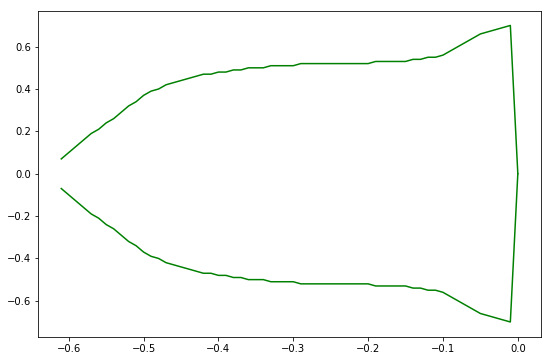

[(-0.0, 0.0),
 (-0.01, 0.7),
 (-0.02, 0.69),
 (-0.03, 0.68),
 (-0.04, 0.67),
 (-0.05, 0.66),
 (-0.06, 0.64),
 (-0.07, 0.62),
 (-0.08, 0.6),
 (-0.09, 0.58),
 (-0.1, 0.56),
 (-0.11, 0.55),
 (-0.12, 0.55),
 (-0.13, 0.54),
 (-0.14, 0.54),
 (-0.15, 0.53),
 (-0.16, 0.53),
 (-0.17, 0.53),
 (-0.18, 0.53),
 (-0.19, 0.53),
 (-0.2, 0.52),
 (-0.21, 0.52),
 (-0.22, 0.52),
 (-0.23, 0.52),
 (-0.24, 0.52),
 (-0.25, 0.52),
 (-0.26, 0.52),
 (-0.27, 0.52),
 (-0.28, 0.52),
 (-0.29, 0.52),
 (-0.3, 0.51),
 (-0.31, 0.51),
 (-0.32, 0.51),
 (-0.33, 0.51),
 (-0.34, 0.5),
 (-0.35, 0.5),
 (-0.36, 0.5),
 (-0.37, 0.49),
 (-0.38, 0.49),
 (-0.39, 0.48),
 (-0.4, 0.48),
 (-0.41, 0.47),
 (-0.42, 0.47),
 (-0.43, 0.46),
 (-0.44, 0.45),
 (-0.45, 0.44),
 (-0.46, 0.43),
 (-0.47, 0.42),
 (-0.48, 0.4),
 (-0.49, 0.39),
 (-0.5, 0.37),
 (-0.51, 0.34),
 (-0.52, 0.32),
 (-0.53, 0.29),
 (-0.54, 0.26),
 (-0.55, 0.24),
 (-0.56, 0.21),
 (-0.57, 0.19),
 (-0.58, 0.16),
 (-0.59, 0.13),
 (-0.6, 0.1),
 (-0.61, 0.07)]

In [60]:
a_zip = zip(goodlistRe,goodlistIm)
l = list(a_zip)

x_val5 = [x[0] for x in l]
y_val5 = [x[1] for x in l]
y1_val5 = [-x[1] for x in l]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

#IDC M=3
#plt.plot(x_val,y_val,'b')
#plt.plot(x_val,y1_val,'b')

#IDC M=4
plt.plot(x_val5,y_val5,'g')
plt.plot(x_val5,y1_val5,'g')
plt.show()


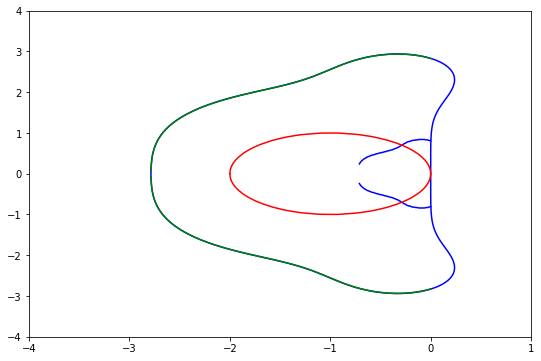

In [61]:


fig, ax = plt.subplots(1, 1, figsize=(9, 6))
a1 = plt.contour(B2,B3,B1,[1],colors='b',label = 'RK4')
#IDC
plt.plot(x_val,y_val,'b')
plt.plot(x_val,y1_val,'b')
#Euler
plt.plot(x_val2,y_val2,'r')
plt.plot(x_val2,y1_val2,'r')
#RK
#plt.plot(x_val1,y_val1,'g')
#plt.plot(x_val1,y1_val1,'g')
plt.plot(x_val3,y_val3,'g')
plt.plot(x_val3,y_val31,'g')

plt.show()






### RIDC

In [172]:
testeq = lambda l,y : l*y

def RIDCtesteq(p,K,l):#Euler
    #(a,b)-endpoints, N-number of steps, p-order of method, K- No. intervals,  y0-I.C, F-function

    
    M = p-1  
    J = int(270/K)
    sol_list = np.zeros(271,dtype = complex) #stores the solution N+1
    sol_list[0] = 1.
    Y = np.zeros((J,K+1),dtype = complex)  #approx solution
    Y1 = np.zeros((J,K+1),dtype = complex)   #corrected solution
    Y[0,0]= 1.           #inital value
    S = np.zeros((M,M+1))  #integration matrix
    
    for m in range(M):   # calculating integration matrix
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)  # constructs polynomial
            para = np.poly1d.integ(p)  
            S[m,i] = para(m+1) - para(m)  #finds definite integral of polynomial and adds to integral matrix
            
    for j in range(J):
        Y[:, 0] = sol_list[j*K]  # predictor starts w last point in j-1 interval
        for m in range(K):   #prediction
            Y[j,m+1] = Y[j,m] + testeq(l,Y[j,m]) #Eulers forward method  
            
        for l1 in range(1,M+1):   #correction
            Y1[j,0] = Y[j,0]
            
            for m in range(M):  
                
                g = sum([S[m,k]*testeq(l,Y[j,k]) for k in range(M+1)])

                Y1[j,m+1] = Y1[j,m] + testeq(l,Y1[j,m])-testeq(l,Y[j,m]) + g #solve error equation with forward Euler
            
            for m in range(M,K):
                
                g = sum([S[M-1,k]*testeq(l,Y[j,m-M+k+1]) for k in range(M+1)])
                
                Y1[j,m+1] = Y1[j,m] + (testeq(l,Y1[j,m])-testeq(l,Y[j,m])) + g  #solve error equation with forward Euler
                    
            Y[j,:] = Y1[j,:]
    
        sol_list[j*K+1:j*K+K+1] = Y1[j,1:K+1]

            
    return sol_list





In [ ]:
a_zip = zip(goodlistRe,goodlistIm)
l = list(a_zip)

x_valridc = [x[0] for x in l]
y_valridc = [x[1] for x in l]
y1_valridc = [-x[1] for x in l]
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(x_valridc,y_valridc,'b')
plt.plot(x_valridc,y1_valridc,'b')
plt.plot(x_val,y_val,'g')
plt.plot(x_val,y1_val,'g')
plt.show()

In [162]:
goodlistRe = []
goodlistIm = []
#Finding the real values that are on the stability interval
for i in np.arange(0,2.005,0.005):
    M = RIDCtesteq(3,270,-i)
    #print(M)
    #df = [abs(M[j]) for j in range(1,11)]
    #print(df)
    r = abs(M[-1])
    #print(r)
    if r<=1.:
        goodlistRe.append(round(-i,6))
#print(goodlistRe)
#finding the maximum imaginary values correcsponding to the real ones that satisfy the amplification factor
for m in goodlistRe:
    goodlistIm1 = []
    for i in np.arange(0,1.005,0.005):
        
        M = RIDCtesteq(3,270,complex(m,i))
        #print(M)
        #dl = [abs(M[j]) for j in range(1,11)]
        #print(df)
        r = abs(M[-1])
        #print(r)
        if r<=1.:
            goodlistIm1.append(round(i,6))

    something = max(goodlistIm1)
    goodlistIm.append(round(something,6))
        

        
goodlistIm,goodlistRe

([0.005,
  0.11,
  0.13,
  0.15,
  0.165,
  0.185,
  0.2,
  0.215,
  0.235,
  0.25,
  0.265,
  0.275,
  0.29,
  0.305,
  0.315,
  0.33,
  0.34,
  0.355,
  0.365,
  0.375,
  0.385,
  0.395,
  0.405,
  0.415,
  0.425,
  0.435,
  0.445,
  0.455,
  0.46,
  0.47,
  0.48,
  0.485,
  0.495,
  0.505,
  0.51,
  0.52,
  0.525,
  0.535,
  0.54,
  0.545,
  0.555,
  0.56,
  0.565,
  0.575,
  0.58,
  0.585,
  0.595,
  0.6,
  0.605,
  0.61,
  0.615,
  0.625,
  0.63,
  0.635,
  0.64,
  0.645,
  0.65,
  0.655,
  0.66,
  0.665,
  0.67,
  0.675,
  0.68,
  0.685,
  0.69,
  0.695,
  0.7,
  0.705,
  0.71,
  0.715,
  0.72,
  0.72,
  0.725,
  0.73,
  0.735,
  0.74,
  0.745,
  0.745,
  0.75,
  0.755,
  0.76,
  0.76,
  0.765,
  0.77,
  0.775,
  0.775,
  0.78,
  0.785,
  0.79,
  0.79,
  0.795,
  0.8,
  0.8,
  0.805,
  0.81,
  0.81,
  0.815,
  0.815,
  0.82,
  0.825,
  0.825,
  0.83,
  0.83,
  0.835,
  0.835,
  0.84,
  0.845,
  0.845,
  0.85,
  0.85,
  0.855,
  0.855,
  0.86,
  0.86,
  0.865,
  0.865,
  0.87,
  0

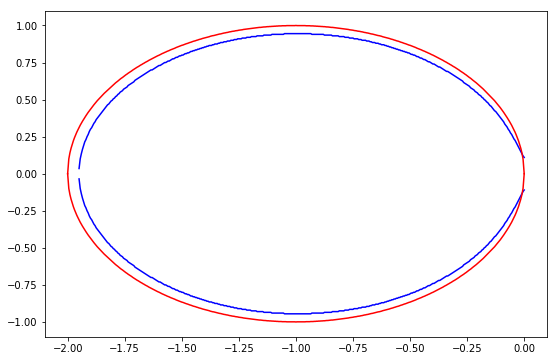

In [94]:
#M=4

a_zip = zip(goodlistRe,goodlistIm)
l = list(a_zip)
x_valridc1 = [x[0] for x in l]
y_valridc1 = [x[1] for x in l]
y1_valridc1 = [-x[1] for x in l]


In [158]:
#M=5

a_zip = zip(goodlistRe,goodlistIm)
l = list(a_zip)
x_valridc2 = [x[0] for x in l]
y_valridc2 = [x[1] for x in l]
y1_valridc2 = [-x[1] for x in l]


In [163]:
#M=3

a_zip = zip(goodlistRe,goodlistIm)
l = list(a_zip)
x_valridc3 = [x[0] for x in l]
y_valridc3 = [x[1] for x in l]
y1_valridc3 = [-x[1] for x in l]

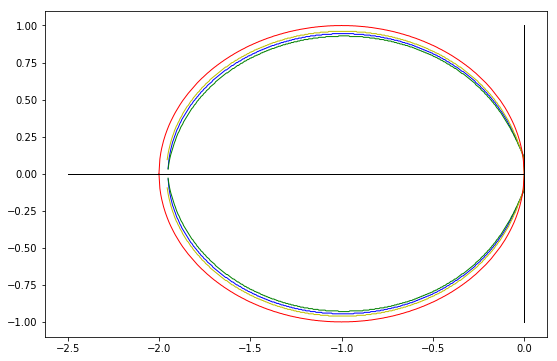

In [171]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.plot(x_valridc1,y_valridc1,'b',linewidth=1)
plt.plot(x_valridc1,y1_valridc1,'b',linewidth=1)
plt.plot(x_valridc2,y_valridc2,'g',linewidth=1)
plt.plot(x_valridc2,y1_valridc2,'g',linewidth=1)
plt.plot(x_valridc3,y_valridc3,'y',linewidth=1)
plt.plot(x_valridc3,y1_valridc3,'y',linewidth=1)
plt.plot(x_val2,y_val2,'r',linewidth=1)
plt.plot(x_val2,y1_val2,'r',linewidth=1)
plt.plot([-2.5, 0], [0, 0], 'k',linewidth=1)
plt.plot([0, 0], [-1, 1], 'k',linewidth=1)
#plt.savefig("RIDCSTABregion.png")
plt.show()